# Principle Component analysis of crowdfunding projects
Data visualization of Kickstarter projects based on suitable visualization techniques including a principal component analysis (PCA).

The dataset was downloaded from
https://www.kaggle.com/kemical/kickstarter-projects 
on September 14th 2018.

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd
import plotly as py
import plotly.graph_objs as go

# use plotly in offline mode:
py.offline.init_notebook_mode(connected=True)

In [152]:
%matplotlib inline

In [153]:
# basic pandas settings
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize'] = (16, 12)

## 1. Data inspection and cleaning

In [154]:
# create the dataframe and define a reduced version with the first 
# 5000 observations of project goal and the total amount pledged
raw_data = pd.read_csv('ks-projects-201801.csv')
cols = ['goal', 'pledged']
df = pd.DataFrame(raw_data, columns = cols)
df_training = df[0:5000] # real training set: df[0:250000]
# df_testing = df[250000:]

# compute (reduced) dataframe dimensions (X = N x M)
N = len(df['goal'])
M = len(cols)

In [156]:
# Initial check for missing values
for i in col:
    if raw_data[i].isnull().sum().sum() != 0:
        print(i)
        print(raw_data[i].isnull().sum().sum())

# 4 missing name values
# 3797 missing usd pledged values
# We won't be using either of these attributes
# so let's not worry about this.

NameError: name 'col' is not defined

In [157]:
# Now for the categories. Let's view them:
cat = raw_data.loc[:,'category']
if cat.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    cat_sort = sorted(set(cat))
    print(cat_sort)

---- No empty strings/None values detected ----
['3D Printing', 'Academic', 'Accessories', 'Action', 'Animals', 'Animation', 'Anthologies', 'Apparel', 'Apps', 'Architecture', 'Art', 'Art Books', 'Audio', 'Bacon', 'Blues', 'Calendars', 'Camera Equipment', 'Candles', 'Ceramics', "Children's Books", 'Childrenswear', 'Chiptune', 'Civic Design', 'Classical Music', 'Comedy', 'Comic Books', 'Comics', 'Community Gardens', 'Conceptual Art', 'Cookbooks', 'Country & Folk', 'Couture', 'Crafts', 'Crochet', 'DIY', 'DIY Electronics', 'Dance', 'Design', 'Digital Art', 'Documentary', 'Drama', 'Drinks', 'Electronic Music', 'Embroidery', 'Events', 'Experimental', 'Fabrication Tools', 'Faith', 'Family', 'Fantasy', "Farmer's Markets", 'Farms', 'Fashion', 'Festivals', 'Fiction', 'Film & Video', 'Fine Art', 'Flight', 'Food', 'Food Trucks', 'Footwear', 'Gadgets', 'Games', 'Gaming Hardware', 'Glass', 'Graphic Design', 'Graphic Novels', 'Hardware', 'Hip-Hop', 'Horror', 'Illustration', 'Immersive', 'Indie Rock',

In [158]:
# We inspect the cat_sort vector and don't
# find any mistakes/errors.

# We'll use 1-of-K encoding. Declare the attribute
# categorical with pandas
raw_data['category'] = pd.Categorical(raw_data['category'])

# 1-of-K and combine w/ raw data
cat_Dummies = pd.get_dummies(raw_data['category'], prefix = 'category')
raw_data = pd.concat([raw_data, cat_Dummies], axis=1)

# Check columns
raw_data.columns.values

array(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real',
       'category_3D Printing', 'category_Academic',
       'category_Accessories', 'category_Action', 'category_Animals',
       'category_Animation', 'category_Anthologies', 'category_Apparel',
       'category_Apps', 'category_Architecture', 'category_Art',
       'category_Art Books', 'category_Audio', 'category_Bacon',
       'category_Blues', 'category_Calendars',
       'category_Camera Equipment', 'category_Candles',
       'category_Ceramics', "category_Children's Books",
       'category_Childrenswear', 'category_Chiptune',
       'category_Civic Design', 'category_Classical Music',
       'category_Comedy', 'category_Comic Books', 'category_Comics',
       'category_Community Gardens', 'category_Conceptual Art',
       'category_Cookbooks', 'category_Country & Folk',
       'ca

In [7]:
# Now for the main categories. Let's view them:
main_cat = raw_data.loc[:,'main_category']
if main_cat.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    main_cat_sort = sorted(set(main_cat))
    print(main_cat_sort)

---- No empty strings/None values detected ----
['Art', 'Comics', 'Crafts', 'Dance', 'Design', 'Fashion', 'Film & Video', 'Food', 'Games', 'Journalism', 'Music', 'Photography', 'Publishing', 'Technology', 'Theater']


In [8]:
# No mistakes/errors. 1-of-K encoding. Declare categorical
raw_data['main_category'] = pd.Categorical(raw_data['main_category'])

# 1-of-K and combine w/ raw data
main_cat_Dummies = pd.get_dummies(raw_data['main_category'], prefix = 'main_cat')
raw_data = pd.concat([raw_data, main_cat_Dummies], axis=1)

# Check columns
raw_data.columns.values

array(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real',
       'category_3D Printing', 'category_Academic',
       'category_Accessories', 'category_Action', 'category_Animals',
       'category_Animation', 'category_Anthologies', 'category_Apparel',
       'category_Apps', 'category_Architecture', 'category_Art',
       'category_Art Books', 'category_Audio', 'category_Bacon',
       'category_Blues', 'category_Calendars',
       'category_Camera Equipment', 'category_Candles',
       'category_Ceramics', "category_Children's Books",
       'category_Childrenswear', 'category_Chiptune',
       'category_Civic Design', 'category_Classical Music',
       'category_Comedy', 'category_Comic Books', 'category_Comics',
       'category_Community Gardens', 'category_Conceptual Art',
       'category_Cookbooks', 'category_Country & Folk',
       'ca

In [9]:
# Now for currencies. Let's view them:
cur = raw_data.loc[:,'currency']
if cur.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    cur_sort = sorted(set(cur))
    print(cur_sort)

---- No empty strings/None values detected ----
['AUD', 'CAD', 'CHF', 'DKK', 'EUR', 'GBP', 'HKD', 'JPY', 'MXN', 'NOK', 'NZD', 'SEK', 'SGD', 'USD']


In [10]:
# No mistakes/errors. Declare categorical
raw_data['currency'] = pd.Categorical(raw_data['currency'])

# 1-of-K and combine w/ raw data
cur_Dummies = pd.get_dummies(raw_data['currency'], prefix = 'currency')
raw_data = pd.concat([raw_data, cur_Dummies], axis=1)

# Check columns
raw_data.columns.values

array(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real',
       'category_3D Printing', 'category_Academic',
       'category_Accessories', 'category_Action', 'category_Animals',
       'category_Animation', 'category_Anthologies', 'category_Apparel',
       'category_Apps', 'category_Architecture', 'category_Art',
       'category_Art Books', 'category_Audio', 'category_Bacon',
       'category_Blues', 'category_Calendars',
       'category_Camera Equipment', 'category_Candles',
       'category_Ceramics', "category_Children's Books",
       'category_Childrenswear', 'category_Chiptune',
       'category_Civic Design', 'category_Classical Music',
       'category_Comedy', 'category_Comic Books', 'category_Comics',
       'category_Community Gardens', 'category_Conceptual Art',
       'category_Cookbooks', 'category_Country & Folk',
       'ca

In [11]:
# As far as the dates go, we'd like to exclude projects that started
# before April of 2009 and projects that ended after September of 2018
# (we only want to look at finished projects)

raw_data['launched'] = pd.to_datetime(raw_data['launched'])
raw_data['deadline'] = pd.to_datetime(raw_data['deadline'])
len(raw_data[raw_data['launched'] < datetime.date(2009,4,1)])

# There are 7 observations that started before Kickstarter's founding month.
# These are removed and checked:
raw_data = raw_data[raw_data['launched'] >= datetime.date(2009,4,1)]
len(raw_data[raw_data['launched'] < datetime.date(2009,4,1)]) == 0

NameError: name 'datetime' is not defined

In [12]:
# Check dates for missing values
if raw_data.launched.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    
if raw_data.deadline.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')

---- No empty strings/None values detected ----
---- No empty strings/None values detected ----


In [13]:
# Now we'd like to go from "launched" and "deadline"
# to "duration" (in days) and "yearlaunched"

# Year launched 
raw_data['yearlaunched'] = pd.DatetimeIndex(raw_data['launched']).year

# Make a new coloum with the new duration
raw_data['duration']=(raw_data['deadline']-raw_data['launched']).astype('timedelta64[h]')/24

In [14]:
# Kickstarter projects used to have a max duration of 90 days (now 60 days).
# Therefore we'd like to cut the projects that have a duration of over 90 days.
len(raw_data[raw_data['duration'] > 90])

# There are 457 such projects. Cut and check:
raw_data = raw_data[raw_data['duration'] < 90]
len(raw_data[raw_data['duration'] > 90]) == 0

True

In [15]:
# Now for the states. Let's view them:
states = raw_data['state']
if states.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    states_sort = sorted(set(states))
    print(states_sort)

# We inspect the states_sort vector and don't
# find any mistakes/errors. We do, however, have canceled, failed, suspended,
# undefined, and live projects.

---- No empty strings/None values detected ----
['canceled', 'failed', 'live', 'successful', 'suspended', 'undefined']


In [16]:
# Let's start by inspecting at the undefined.
undefined = raw_data[states == 'undefined']
print(undefined)

                ID                                               name  \
169     1000694855                      STREETFIGHTERZ WHEELIE MURICA   
328      100149523                        Duncan Woods - Chameleon EP   
632     1003023003          The Making of Ashley Kelley's Debut Album   
647     1003130892                       Butter Side Down Debut Album   
749     1003629045                            Chase Goehring debut EP   
824     1004013077           Spencer Capier Instrumental Project 2015   
844     1004126342  LUKAS LIGETI'S 50TH BIRTHDAY FESTIVAL: ORIGINA...   
864     1004255433      The Battle For Breukelen: A Neighborhood Epic   
870     1004298993  "Tamboura Plays Violin" - a collection of Pop ...   
890     1004402863        Nightingale Noel - An A Cappella Holiday CD   
1026    1005185256                             Local Music Connection   
1036     100522240  DO NOT DUPLICATE - Selected by 2015 Devon Film...   
1116    1005653464                                 

In [17]:
# Seems like most of the undefined are in main categories "Music",
# "Publishing" or "Film & Video":
(len(undefined[undefined['main_category'] == 'Music'])+len(undefined[undefined['main_category'] == 'Publishing'])+len(undefined[undefined['main_category'] == 'Film & Video']))/len(undefined)

# 99.7 percent of undefined projects were in these categories. But based on
# what we're doing, we can't really use undefined projects for anything, so
# we'll take these rows out.
raw_data = raw_data[raw_data['state'] != 'undefined']
len(raw_data[raw_data['state'] == 'undefined']) == 0

True

In [18]:
# Let's inspect the paused projects.
len(raw_data[states == 'suspended'])

# There are about 1800 of these. We'll take them out as well, since they don't
# help us.
raw_data = raw_data[raw_data['state'] != 'suspended']
len(raw_data[raw_data['state'] == 'suspended']) == 0

C:\Users\User\AppData\Local\Programs\Python\Python36\Lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


True

In [19]:
# Now for canceled projects:
len(raw_data[states == 'canceled'])

# About 10% of projects in the data set have been canceled. Let's keep these
# in and see if the algorithm can guess which projects will be canceled.

C:\Users\User\AppData\Local\Programs\Python\Python36\Lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


38751

In [20]:
# Now for live projects:
len(raw_data[states == 'live'])

# There are about 2800 of these. The data was pulled in January 2018, so
# let's see what that means in terms of end dates.
live = raw_data[raw_data['state'] == 'live'].sort_values(by = 'deadline')
live

C:\Users\User\AppData\Local\Programs\Python\Python36\Lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD,yearlaunched,duration
371277,961951460,Jahque Inc. is merging with Reesi's Cakes 'N T...,Events,Food,USD,2016-05-05,25000.0,2016-04-05 06:01:09,0.0,live,...,0,0,0,0,0,0,0,1,2016,29.708333
339521,79946509,Omnicharge: Smart & Compact Portable Power Bank,Gadgets,Technology,USD,2016-08-08,8000.0,2016-07-25 23:57:23,7035.0,live,...,0,0,0,0,0,0,0,1,2016,13.000000
304386,619709625,Escapsim,Film & Video,Film & Video,USD,2017-02-16,5000.0,2017-01-07 21:54:19,30.0,live,...,0,0,0,0,0,0,0,1,2017,39.083333
19716,1100111323,DAWSON HOLLOW,Indie Rock,Music,USD,2017-04-20,40000.0,2017-03-17 18:06:01,20.0,live,...,0,0,0,0,0,0,0,1,2017,33.208333
229599,237278551,Flyboard Air®,Technology,Technology,EUR,2017-08-15,250000.0,2017-07-16 14:56:18,520.0,live,...,0,0,0,0,0,0,0,0,2017,29.375000
44312,1225234610,The Hali Erickson Project,Pop,Music,USD,2017-11-12,3000.0,2017-10-13 21:32:39,320.0,live,...,0,0,0,0,0,0,0,1,2017,29.083333
178739,1909388163,Black Watch: Italian carbon fibre watch - Swis...,Product Design,Design,EUR,2017-12-15,35000.0,2017-11-15 16:56:52,6714.0,live,...,0,0,0,0,0,0,0,0,2017,29.291667
14963,1075403725,Sonic Soak: The Ultimate Ultrasonic Cleaning Tool,Technology,Technology,USD,2018-01-01,10000.0,2017-12-12 22:23:55,5238.0,live,...,0,0,0,0,0,0,0,1,2017,19.041667
297562,585070118,The Reading Pig,Children's Books,Publishing,USD,2018-01-02,3490.0,2017-11-29 20:33:39,495.0,live,...,0,0,0,0,0,0,0,1,2017,33.125000
253230,357867886,"""George the Turtle"" A hilarious and magical ki...",Publishing,Publishing,GBP,2018-01-02,7000.0,2017-11-27 13:36:14,2100.0,live,...,0,0,0,0,0,0,0,0,2017,35.416667


In [21]:
# The first 7 examples are mistakes of some sort. Let's see what's up:
live.iloc[0:7,:]['usd_pledged_real'] - live.iloc[0:7,:]['usd_goal_real']

371277    -25000.00
339521      -965.00
304386     -4970.00
19716     -39980.00
229599   -292889.09
44312      -2680.00
178739    -33394.33
dtype: float64

In [25]:
# Its seems that all these projects actually failed. Let's change their status.
# Copy slice
notlive = raw_data['state'][raw_data['deadline'] < datetime.date(2018,1,1)][raw_data['state'] == 'live'].copy()

# Edit copy
for i in range(len(notlive)):
    notlive.iloc[i] = 'failed'

NameError: name 'datetime' is not defined

In [23]:
# Update original dataframe and check
raw_data.update(notlive)
len(raw_data['state'][raw_data['deadline'] < datetime.date(2018,1,1)][raw_data['state'] == 'live']) == 0

# Delete rest of the live values and check
raw_data = raw_data[raw_data['state'] != 'live']
len(raw_data[raw_data['state'] == 'live']) == 0

NameError: name 'notlive' is not defined

In [26]:
# Let's view states again
states_1 = raw_data.loc[:,'state']
if states_1.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    states_1_sort = sorted(set(states_1))
    print(states_1_sort)

---- No empty strings/None values detected ----
['canceled', 'failed', 'live', 'successful']


In [27]:
# No mistakes/errors. Declare categorical
raw_data['state'] = pd.Categorical(raw_data['state'])

# 1-of-K and combine w/ raw data
state_Dummies = pd.get_dummies(raw_data['state'], prefix = 'state')
raw_data = pd.concat([raw_data, state_Dummies], axis=1)

In [28]:
# Let's look at backers. Check for missing values
if raw_data.backers.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')

---- No empty strings/None values detected ----


In [29]:
# Now for the countries. Let's view them:
if raw_data.country.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    countries = raw_data.country
    print('---- No empty strings/None values detected ----')
    countries_sort = sorted(set(countries))
    print(countries_sort)

---- No empty strings/None values detected ----
['AT', 'AU', 'BE', 'CA', 'CH', 'DE', 'DK', 'ES', 'FR', 'GB', 'HK', 'IE', 'IT', 'JP', 'LU', 'MX', 'N,0"', 'NL', 'NO', 'NZ', 'SE', 'SG', 'US']


In [159]:
# 'N,0"' is clearly a mistake.
raw_data.country[raw_data.country == 'N,0"']

169       N,0"
328       N,0"
632       N,0"
647       N,0"
749       N,0"
          ... 
378233    N,0"
378303    N,0"
378434    N,0"
378585    N,0"
378588    N,0"
Name: country, Length: 3797, dtype: object

In [160]:
# For whatever reason there are 233 of these observations. No clue what that
# means. Let's check currency for these observations
raw_data.currency[raw_data.country == 'N,0"']

169       USD
328       AUD
632       USD
647       USD
749       USD
         ... 
378233    USD
378303    CAD
378434    USD
378585    GBP
378588    EUR
Name: currency, Length: 3797, dtype: object

In [32]:
# All sorts of different currencies. Let's check more generally.
raw_data[raw_data.country == 'N,0"'].sort_values(by = 'usd_pledged_real')

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,currency_NZD,currency_SEK,currency_SGD,currency_USD,yearlaunched,duration,state_canceled,state_failed,state_live,state_successful
289718,544130636,Anabella and The Lost Kingdom-- short film,Film & Video,Film & Video,USD,2016-05-27,4500.0,2016-05-02 21:02:32,0.00,canceled,...,0,0,0,1,2016,24.083333,1,0,0,0
74887,1381563978,Butterfield VHS Tape Recovery Project,Film & Video,Film & Video,USD,2016-05-29,1200.0,2016-04-29 22:34:34,0.00,canceled,...,0,0,0,1,2016,29.041667,1,0,0,0
291121,551357943,XHuman,Music,Music,USD,2016-05-27,5000.0,2016-03-28 16:24:08,0.00,failed,...,0,0,0,1,2016,59.291667,0,1,0,0
42065,121413755,have you seen jordan?,Music,Music,USD,2016-06-22,3200.0,2016-04-23 06:19:25,0.00,canceled,...,0,0,0,1,2016,59.708333,1,0,0,0
44594,1226622252,Documentary: A Child Of Their Own,Film & Video,Film & Video,USD,2016-05-13,15000.0,2016-04-28 11:28:39,0.00,canceled,...,0,0,0,1,2016,14.500000,1,0,0,0
110744,1562642889,ALL R.I.S.E,Publishing,Publishing,USD,2016-05-28,2000.0,2016-04-29 12:20:45,0.00,canceled,...,0,0,0,1,2016,28.458333,1,0,0,0
204855,2043615574,What you should NEVER do to live a Happy Life!,Publishing,Publishing,USD,2016-05-26,5000.0,2016-04-26 20:34:15,0.00,failed,...,0,0,0,1,2016,29.125000,0,1,0,0
104899,153316291,XCIV,Music,Music,AUD,2016-05-28,4000.0,2016-04-28 10:48:20,0.00,failed,...,0,0,0,0,2016,29.541667,0,1,0,0
248827,335528748,Beyond Tha Means,Publishing,Publishing,USD,2016-04-24,3500.0,2016-04-20 12:12:28,0.00,failed,...,0,0,0,1,2016,3.458333,0,1,0,0
196363,1999958521,"""Color"" Music Video",Film & Video,Film & Video,USD,2016-06-06,5000.0,2016-05-07 01:56:36,0.00,canceled,...,0,0,0,1,2016,29.916667,1,0,0,0


In [33]:
# Let's not delete these values. At least one of these projects seem significant
# (there's one with over 2.7 mio USD pledged).

# 1-of-K encoding. Declare categorical
raw_data.country = pd.Categorical(raw_data.country)

# 1-of-K and combine w/ raw data
country_Dummies = pd.get_dummies(raw_data.country, prefix = 'country')
raw_data = pd.concat([raw_data, country_Dummies], axis=1)

In [34]:
# We only want to use usd_pledged_real and usd_goal_real, so we'll delete
# everything else. Now we'll also delete the ID and name columns, and the
# categorical variables that we've 1-of-K encoded.

# First let's check usd_pledged_real and usd_goal_real. Check for missing values:
pledged = raw_data.usd_pledged_real
if pledged.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')
    
goal = raw_data.usd_goal_real
if goal.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    print('---- No empty strings/None values detected ----')

---- No empty strings/None values detected ----
---- No empty strings/None values detected ----


In [35]:
# Check for negatives:
len(raw_data[raw_data['usd_pledged_real'] < 0])
len(raw_data[raw_data['usd_goal_real'] < 0])

0

In [36]:
# Let's 1-of-K the yearlaunched attribute
# Check for missing values
if raw_data.yearlaunched.isnull().values.any():
    print('---- Empty string/None values detected ----')
else:
    yr = raw_data.yearlaunched
    print('---- No empty strings/None values detected ----')
    yr_sort = sorted(set(yr))
    print(yr_sort)

---- No empty strings/None values detected ----
[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


In [37]:
# No mistakes/errors. Declare categorical
raw_data['yearlaunched'] = pd.Categorical(raw_data['yearlaunched'])

# 1-of-K and combine w/ raw data
yr_Dummies = pd.get_dummies(raw_data['yearlaunched'], prefix = 'yearlaunched')
raw_data = pd.concat([raw_data, yr_Dummies], axis=1)

In [38]:
# Now let's take the important part of the data
backers_data = raw_data.backers
cleaned_data = pd.concat([backers_data, raw_data.iloc[:,13:]], axis=1)
cleaned_data = cleaned_data.drop(['yearlaunched'], axis = 1)
cleaned_data.columns.values

# Check one last time for missing data
cleaned_data.isnull().sum().sum() == 0

# ----------- OUTPUT FOR ALL OF THIS IS THE DATAFRAME cleaned_data -------
# ----------- FOR PCA, RATIO ATTRIBUTES STILL NEED TO BE NORMALIZED ------
# ----------- FOR PLOTS, OUTLIERS NEED TO BE TAKEN OUT -------------------

True

In [126]:
# The various preprocessing steps have changed the
# dimensions of the dataset. Let's see what we have in total:
np.shape(cleaned_data)

(372758, 229)

## 2. Visualizations



On average, projects in this dataset were launched 5.24 years after Kickstarter was founded.


[Text(0.5,1,'Number of projects per year')]

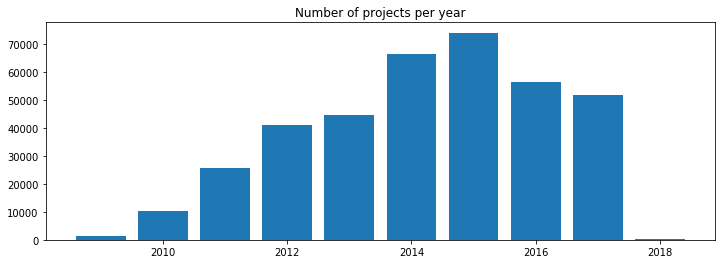

In [113]:
# In which year did projects start?

# create a list of indices to address the individual years
yearlaunched_index_ = list('yearlaunched_' + str(yr_sort[i]) for i in range(len(yr_sort)))

# sum up number of projects per year and store in list
projects_per_year = list(cleaned_data[yearlaunched_index_[year]].sum() for year in range(len(yr_sort)))

# calculate mean launchyear relative to Kickstarter founding.
years_after_launch = np.arange(10)
mean_launchyear = sum(projects_per_year*years_after_launch)/sum(projects_per_year)
print('On average, projects in this dataset were launched', \
      '%.2f' % mean_launchyear, 'years after Kickstarter was founded.')

fig, ax = plt.subplots(figsize=(12,4))
ax.bar(yr_sort, projects_per_year)
ax.set(title='Number of projects per year')


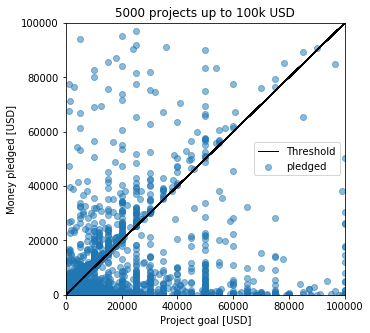

In [102]:
# plot a simple relationship
fig, ax = plt.subplots(figsize=(5,5))
ax.set(title='5000 projects up to 100k USD',
      xlabel='Project goal [USD]', ylabel='Money pledged [USD]',
      xlim=[0, 100000], ylim=[0, 100000])
ax.scatter(df_training['goal'], df_training['pledged'], alpha=0.5)
ax.plot(df_training['goal'], df_training['goal'], color='black', linewidth=1, label='Threshold')
ax.legend()
# idea: split dataset
success_mask = [df_training['pledged'] >= df_training['goal']]
# 'succeeded'-color blue, else 'failed'-red 

## 3. Principle component analysis

Next up is decomposing this set into its principal components. The mean value of all interval or ratio data is computed and stored as pandas object `means`, thre respective standard deviations are calculated using numpy's `std()`. 

The data is then normalized to prepare it for the singular value decomposition. As attribute values differ by orders of magnitude, they are all divided by their standard deviation (eg. compare number of backers: ~$10^2$ to funding goals: ~$10^4$).

In [147]:
# Extract all interval or ratio columns for normalization and calculate mean.

interval_or_ratio = ['backers', 'usd_pledged_real', 'usd_goal_real', 'duration']

means = round(cleaned_data[interval_or_ratio].mean())
print('Mean values of interval or ratio attributes:\n')
print(means)

standard_deviations = round(np.std(cleaned_data[interval_or_ratio]))
print('\nStandard deviations:\n')
print(standard_deviations)                            

Mean values of interval or ratio attributes:

backers               107.0
usd_pledged_real     9131.0
usd_goal_real       45214.0
duration               34.0
dtype: float64

Standard deviations:

backers                 913.0
usd_pledged_real      91420.0
usd_goal_real       1136364.0
duration                 13.0
dtype: float64


In [181]:
# Subtract mean value from data and divide by standard deviation
normalized = (cleaned_data[interval_or_ratio] - means)/standard_deviations

# PCA by computing SVD of Y
U,S,V = svd(normalized,full_matrices=False)
# print('U[0] = ', U[0], '\nS[0] =', S[0], '\nV[0] =', V[0])

# Compute variance explained by principal components
rho = (S**2) / (S**2).sum()


# Plot variance explained

# I've decided to implement the graphs in plotly because the
# interactiveness can become really helpful with more complex plots later on

layout = go.Layout(title='Variance explained', 
                   xaxis=dict(title='Principal component', dtick=1), 
                   yaxis=dict(title='Variance explained'),
                   )

trace = go.Scatter(
    x = np.arange(1,len(rho)+1),
    y = rho
)

data = [trace]

fig = go.Figure(data=[trace], layout=layout)
py.offline.iplot(fig)


# should you prefer matplotlib, this block gives the same output:

# fig, ax = plt.subplots(figsize=(4,4))
# ax.plot(range(1,len(rho)+1),rho,'o-')
# ax.set(title='Variance explained by principal components', 
#         xlabel='Principal component', ylabel='Variance explained', 
#        xticks=[1,2,3,4])

In [162]:
normalized_int_rat = cleaned_data[interval_or_ratio] - means
print(normalized_int_rat)

        backers  usd_pledged_real  usd_goal_real  duration
0       -107.00         -9,131.00     -43,680.05     24.46
1        -92.00         -6,710.00     -15,214.00     25.79
2       -104.00         -8,911.00        -214.00     10.96
3       -106.00         -9,130.00     -40,214.00     -4.17
4        -93.00         -7,848.00     -25,714.00     21.62
...         ...               ...            ...       ...
378656  -106.00         -9,106.00       4,786.00     -4.12
378657  -102.00         -8,976.00     -43,714.00     -7.17
378658  -106.00         -9,111.00     -30,214.00     11.17
378659  -101.00         -8,931.00     -30,214.00     -3.79
378660   -90.00         -8,607.00     -43,214.00     -6.42

[372758 rows x 4 columns]
